In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# set random state
random.seed(50)

In [7]:
# read in the csvs
all_states_df = pd.read_csv('data/ALL.csv')
pop_df = pd.read_csv('data/POPDATELOCATION.csv')
energy_df = pd.read_csv('data/Energy.csv')

In [ ]:
# helper function to replace/impute temperature NaN values
      # NaN values pull from the same month, previous year
      # if that is STILL NaN, it then takes the value from the month before
  # input:
    # data: dataframe from all_states_preprocess
  # output:
    # data: dataframe with all NaN values replaced for T_AVG

def nan_replace(df):

  # get list of NaN indexes
  nan_indexes = df[df['T_AVG'].isnull()].index

  # for loop through the NaN values
  for i in nan_indexes:
    year = df['YEAR'].loc[i]
    month = df['MONTH'].loc[i]
    previous_val = df.loc[(df['MONTH'] == month) & (df['YEAR'] == year-1), 'T_AVG'].iloc[0]

    # NaN val check
    if np.isnan(previous_val):
      df['T_AVG'].loc[i] = df['T_AVG'].loc[i-1]
    else:
      df.at[i, 'T_AVG'] = previous_val

  # return
  return df



In [ ]:
# create a function that takes all_states_df and filters for desired state and converts to a final dataframe for arima modeling
  # inputs:
    # data: dataframe, all_states_df
    # state: str, string of state code desired (e.g. 'AZ')
  # output:
    # dataframe with datetime index and T_avg

def all_states_preprocess(data, state):
  # create a copy
  data_filtered = data.copy()

  # filter for desired state
  data_filtered = data_filtered.loc[data_filtered['State'] == state]

  # rename temperature column
  data_filtered.rename(columns = {'MAX(cse6242.AK_1.DailyAverageDryBulbTemperature)': 'T_AVG'}, inplace = True)

  # sort the month, year
  data_filtered = data_filtered.sort_values(['YEAR', 'MONTH'])

  # convert the temperature column to numeric, coerce the strings to NaN
  data_filtered['T_AVG'] = pd.to_numeric(data_filtered['T_AVG'], errors = 'coerce')

  # for NaN values, pull the value from the same month, but previous year
  data_filtered = nan_replace(data_filtered)

  # make a date column
  data_filtered['DATE'] = pd.to_datetime(data_filtered['YEAR'].astype(str) + '-' + data_filtered['MONTH'].astype(str), format='%Y-%m')

  # select the temperature and date column
  data_filtered = data_filtered[['DATE', 'T_AVG']]

  # set date column as index
  data_filtered = data_filtered.set_index('DATE')

  # set frequency period
  data_filtered.index.freq = 'MS'


  # return
  return data_filtered

In [ ]:
# function to split the filtered data into training, validation, and testing set
# use 70-30 split for train-test
  # input:
    # data: filtered dataframe from all_states_preprocess
  # output:
    # train_df, test_df: dataframes

def train_test_split(data):
  # get the 70% index
  test_index = int(len(data)*0.7)

  # make the dataframes
  train_df = data[:test_index]
  test_df = data[test_index:]

  # return
  return train_df, test_df

In [ ]:
# function for hyperparameter tuning for arima models
  # inputs:
    # train_df: dataframe, training dataset
    # p_values, d_values, q_values: [int] array, contains the integers values we want to search through
  # outputs:
    # best_mse: best mse from hyperparameter tuning
    # best_aic: best aic from hyperparameter tuning
    # best_params: best p,d,q from hyperparameter tuning

def hyperparameter_tuning(train_df, p_values,d_values,q_values):
  # set variables for best mse & best parameters
  best_mse = float('inf')
  best_aic = float('inf')
  best_params = None

  # split train_df into a train-validation set, 80-20 split
  val_index = int(len(train_df)*0.8)
  train_tune = train_df[:val_index]
  val_tune = train_df[val_index:]

  # for loop for grid search
  for p,d,q in product(p_values, d_values, q_values):

    # Fit ARIMA model
    model = ARIMA(train_tune, order=(p,d,q))
    model_fitted = model.fit()

    # forecast
    forecast_values = model_fitted.forecast(steps = len(val_tune))

    # calculate mse
    mse = mean_squared_error(val_tune, forecast_values)

    # calculate aic
    aic = model_fitted.aic

    # if aic < best_aic:
    #   best_aic = aic
    #   best_params = (p,d,q)

    # check for best mse
    if mse < best_mse and aic < best_aic:
       best_mse = mse
       best_params = (p,d,q)
       best_aic = aic

  # return
  return best_mse, best_aic, best_params

In [ ]:
# main forecasting function to get forecasted temperatures from Apr 2024 to Dec 2040
  # inputs:
    # data: main all_states_df dataFrame
    # state: string for state abbrv (e.g. "DE")
    # p_values: list of p_values for tuning
    # d_values: list of d_values for tuning
    # q_values: list of q_values for tuning
  # outputs:
    # forecasted_temps: dataFrame of forecasted temperatures
    # test_mse: mse value for test dataset
    # best_mse: mse value for training dataset
    # best_aic: aic value for training dataset
    # best_params: tuple (p,d,q) for tuned hyperparameters

def get_forecast_2040(data, state, p_values, d_values, q_values):
  # filter the data for the desired state
  data_filtered = all_states_preprocess(data, state)

  # train-test split
  train_df, test_df = train_test_split(data_filtered)

  # hyperparameter tuning
  best_mse, best_aic, best_params = hyperparameter_tuning(train_df, p_values, d_values, q_values)

  # Fit ARIMA model
  model = ARIMA(train_df, order= best_params)
  model_fitted = model.fit()

  # Get test_mse
  forecast_test_values = model_fitted.forecast(steps = len(test_df))
  test_mse = mean_squared_error(test_df, forecast_test_values)

  # Get forecasted temps
  forecasted_temps = model_fitted.predict(start = '2020-04-01', end = '2040-12-01')

  # return
  return pd.DataFrame(forecasted_temps), test_mse, best_mse, best_aic, best_params


In [ ]:
### DO NOT CASUALLY RE-RUN THIS CELL: RUNTIME IS LONG AS IT TUNES A MODEL FOR EACH STATE ###
# hyperparameter search values

# for grid search
# p_values = [0,1,2]
# d_values = [0,1,2]
# q_values = [0,1,2]

# for random search
random.seed(50)
p_values = random.sample(range(0,5),3)
d_values = [0,1,2]
q_values = random.sample(range(0,5),3)

# list of states
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# setup lists to capture training mses and params per state
training_mses = []
training_aics = []
test_mses = []
tuned_hyperparameters = []

# set up dataframe for collecting the temperatures
date_range = pd.date_range(start='2024-04-01', end='2040-12-01', freq = 'MS')
temps_df = pd.DataFrame(index=date_range)

for state in states:
  forecasted_temps, test_mse, best_mse, best_aic, best_params = get_forecast_2040(all_states_df, state, p_values, d_values, q_values)
  training_mses.append(best_mse)
  training_aics.append(best_aic)
  test_mses.append(test_mse)
  tuned_hyperparameters.append(best_params)
  temps_df[state] = forecasted_temps['predicted_mean']


In [ ]:
# placing all the metrics in a table
metrics_df = pd.DataFrame({'State': states, 'Training_MSE': training_mses, 'AIC': training_aics, 'Test_MSE': test_mses, 'Hyperparameters':tuned_hyperparameters})
metrics_df

,State,Training_MSE,AIC,Test_MSE,Hyperparameters
0,AL,7.616766,478.416277,95.869174,"(3, 1, 4)"
1,AK,23.112637,582.267581,12.643878,"(3, 0, 4)"
2,AZ,11.417682,545.840411,44.567661,"(3, 0, 1)"
3,AR,13.201584,518.507035,12.080258,"(2, 0, 3)"
4,CA,13.865810,536.144536,20.620720,"(2, 1, 3)"
5,CO,403.559586,794.592858,336.984996,"(2, 0, 4)"
6,CT,21.965142,571.186851,23.876347,"(2, 1, 4)"
7,DE,12.637259,574.987496,21.100761,"(3, 1, 4)"
8,FL,2.867738,401.492697,3.287491,"(2, 1, 3)"
9,GA,7.797121,477.621095,8.360045,"(2, 1, 3)"


In [ ]:
temps_df

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
2024-04-01,83.723850,57.396963,87.092047,76.531383,91.162527,60.547248,61.574337,72.326702,84.202914,80.995177,...,70.502387,72.673729,84.880447,61.945138,60.298196,78.183334,74.926650,69.638686,64.250546,64.489729
2024-05-01,88.089276,64.924223,91.026984,82.110805,100.901794,81.464938,70.706568,78.807997,86.513244,85.282849,...,81.151890,78.768561,89.347106,72.369123,70.608753,84.032000,82.367638,74.942967,75.424027,73.800257
2024-06-01,91.116457,69.856232,93.285719,86.846540,107.822037,93.968142,79.320595,84.316969,88.585385,88.529669,...,88.121935,84.030029,93.281013,80.654248,79.120301,88.388045,86.323056,80.478983,84.262758,80.827318
2024-07-01,92.088419,72.341805,93.300748,89.478757,110.062096,94.680258,85.131799,86.792884,89.866875,89.864423,...,90.286135,87.059784,95.640197,84.625111,83.559245,90.088009,85.717717,82.889653,88.542633,83.683614
2024-08-01,90.652335,70.252899,91.119995,89.308151,107.019648,83.409971,86.599094,86.154802,90.018178,88.932963,...,86.318068,87.054801,95.801444,83.268972,82.740158,88.680199,80.717897,83.418557,86.983108,81.602121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-08-01,88.521490,70.431383,85.238503,89.173778,104.624610,67.684282,85.013093,85.029607,88.874422,86.057151,...,83.294154,86.074009,94.638219,73.008935,83.359438,87.912079,67.980271,82.833084,87.793780,80.380383
2040-09-01,84.755910,65.671335,84.789165,88.037043,95.955147,44.393627,86.486629,81.929642,88.287544,83.141799,...,73.541639,85.140549,94.794512,71.747088,78.911865,84.448468,59.911389,81.477397,82.131837,73.130492
2040-10-01,80.606925,58.573978,84.439605,84.483326,85.797735,22.706035,83.257214,76.742089,86.998326,79.781368,...,62.428119,81.687781,92.979932,68.617311,70.448609,79.391407,54.473098,78.469995,72.401713,63.777586
2040-11-01,77.192351,51.597590,84.281345,79.459760,76.884348,8.479585,76.181684,70.846948,85.353304,76.881663,...,53.154525,76.637199,89.678040,64.465686,60.230921,74.095367,53.144399,73.029335,61.226017,54.833804


Text(0, 0.5, 'temperature (°F)')

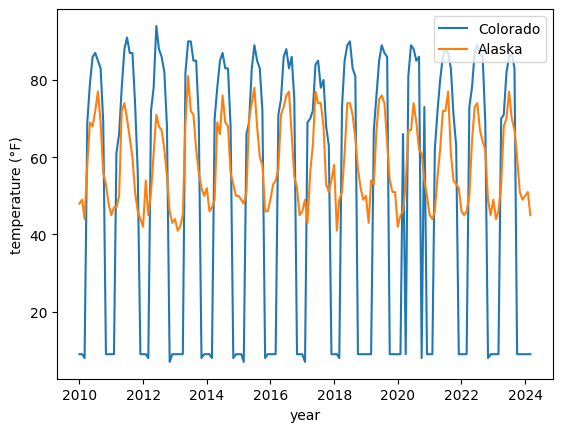

In [ ]:
# COLORADO EXPLANATION
co_df = all_states_preprocess(all_states_df, "CO") # blue
plt.plot(co_df, label = "Colorado")

ak_df = all_states_preprocess(all_states_df, "AK") # orange
plt.plot(ak_df, label = "Alaska")

plt.legend(loc = "upper right")
plt.xlabel("year")
plt.ylabel("temperature (°F)")


In [ ]:
recorded=all_states_df.copy()

#rename temperature column
recorded.rename(columns = {'MAX(cse6242.AK_1.DailyAverageDryBulbTemperature)': 'T_AVG'}, inplace = True)

#sort the month, year
recorded = recorded.sort_values(['YEAR', 'MONTH'])

#make a date column
recorded['DATE'] = pd.to_datetime(recorded['YEAR'].astype(str) + '-' + recorded['MONTH'].astype(str), format='%Y-%m')

#select the state, temperature, and date column
recorded= recorded[['State','DATE', 'T_AVG']]

# set date column as index
recorded = recorded.set_index('DATE')
recorded['T_AVG'] = pd.to_numeric(recorded['T_AVG'], errors = 'coerce')
recorded = recorded.pivot_table(index='DATE', columns='State', values='T_AVG', aggfunc='max')

#Change indexes
recorded.columns.name = None
recorded.index.name = None

#Edit in the missing values from data from a year ago
recorded_shifted=recorded.shift(freq=pd.DateOffset(years=1))
recorded_edited= recorded.fillna(recorded_shifted)
#If still error, average between the past and next month
recorded_edited= recorded_edited.interpolate(method='linear')
recorded_edited

,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2010-01-01,48.0,67.0,65.0,64.0,69.0,9.0,50.0,53.0,80.0,64.0,...,39.0,59.0,76.0,40.0,59.0,46.0,58.0,38.0,53.0,47.0
2010-02-01,49.0,61.0,59.0,64.0,71.0,9.0,44.0,40.0,78.0,61.0,...,34.0,54.0,73.0,47.0,48.0,39.0,55.0,35.0,46.0,39.0
2010-03-01,44.0,72.0,72.0,71.0,76.0,8.0,58.0,63.0,79.0,69.0,...,67.0,65.0,80.0,60.0,68.0,49.0,57.0,65.0,60.0,55.0
2010-04-01,58.0,77.0,78.0,76.0,85.0,69.0,71.0,79.0,82.0,76.0,...,70.0,77.0,88.0,65.0,83.0,70.0,66.0,72.0,78.0,59.0
2010-05-01,69.0,85.0,83.0,83.0,89.0,79.0,82.0,78.0,86.0,82.0,...,81.0,82.0,88.0,77.0,84.0,78.0,72.0,84.0,77.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,51.0,81.0,76.0,77.0,74.0,9.0,60.0,63.0,85.0,72.0,...,64.0,71.0,83.0,61.0,69.0,52.0,59.0,61.0,64.0,56.0
2023-12-01,49.0,72.0,68.0,70.0,71.0,9.0,55.0,57.0,82.0,70.0,...,56.0,60.0,79.0,47.0,69.0,53.0,61.0,52.0,59.0,52.0
2024-01-01,50.0,71.0,61.0,69.0,77.0,9.0,52.0,64.0,81.0,76.0,...,45.0,61.0,78.0,49.0,72.0,42.0,60.0,43.0,60.0,49.0
2024-02-01,51.0,72.0,76.0,72.0,70.0,9.0,50.0,60.0,80.0,70.0,...,56.0,72.0,82.0,52.0,66.0,49.0,56.0,64.0,62.0,53.0


In [ ]:
#Combine recorded data with our predicted data
combined= pd.concat([recorded_edited,temps_df])

#Calculation for Heating days
combined_HD=(65-combined)

#get rid of negative Heating days
combined_HD[combined_HD<0]=0

#Multiply the month's data by the number of days
from calendar import monthrange
for index, row in combined_HD.iterrows():
    # Get the year and month from the index
    year = index.year
    month = index.month

    # Get the number of days in the month
    num_days = monthrange(year, month)[1]

    # Multiply each value in the row by the number of days
    combined_HD.loc[index] *= num_days

#Convert data to integer (I guess it's not really needed to be in integer..)
combined_HD=combined_HD.astype(int)
combined_HD

,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2010-01-01,527,0,0,31,0,1736,465,372,0,31,...,806,186,0,775,186,589,217,837,372,558
2010-02-01,448,112,168,28,0,1568,588,700,0,112,...,868,308,0,504,476,728,280,840,532,728
2010-03-01,651,0,0,0,0,1767,217,62,0,0,...,0,0,0,155,0,496,248,0,155,310
2010-04-01,210,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,180
2010-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-08-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2040-09-01,0,0,0,0,0,618,0,0,0,0,...,0,0,0,0,0,0,152,0,0,0
2040-10-01,199,0,0,0,0,1311,0,0,0,0,...,79,0,0,0,0,0,326,0,0,37
2040-11-01,402,0,0,0,0,1695,0,0,0,0,...,355,0,0,16,0,143,355,113,0,304


In [ ]:
#Calculation for cooling days
combined_CD=(combined-65)

#get rid of negative Cooling days
combined_CD[combined_CD<0]=0

#Multiply the month's data by the number of days
for index, row in combined_CD.iterrows():
    # Get the year and month from the index
    year = index.year
    month = index.month

    # Get the number of days in the month
    num_days = monthrange(year, month)[1]

    # Multiply each value in the row by the number of days
    combined_CD.loc[index] *= num_days

#Convert data to integer (I guess it's not really needed to be in integer..)
combined_CD=combined_CD.astype(int)
combined_CD

,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2010-01-01,0,62,0,0,124,0,0,0,465,0,...,0,0,341,0,0,0,0,0,0,0
2010-02-01,0,0,0,0,168,0,0,0,364,0,...,0,0,224,0,0,0,0,0,0,0
2010-03-01,0,217,217,186,341,0,0,0,434,124,...,62,0,465,0,93,0,0,0,0,0
2010-04-01,0,360,390,330,600,120,180,420,510,330,...,150,360,690,0,540,150,30,210,390,0
2010-05-01,124,620,558,558,744,434,527,403,651,527,...,496,527,713,372,589,403,217,589,372,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040-08-01,168,729,749,627,1228,83,620,620,740,652,...,567,653,918,248,710,569,92,706,552,476
2040-09-01,20,592,691,593,928,0,644,507,698,544,...,256,604,893,202,583,417,0,513,494,243
2040-10-01,0,483,603,602,644,0,565,364,681,458,...,0,517,867,112,446,168,0,229,417,0
2040-11-01,0,365,433,578,356,0,335,175,610,356,...,0,349,740,0,272,0,0,0,240,0


In [ ]:
#add all the month's data to one year
CD_total= combined_CD.resample('Y').sum()

#Change display to just year
CD_total.index =CD_total.index.strftime('%Y')

#Reformat the dataframe
CD_formatted = CD_total.stack().reset_index()
CD_formatted.columns = ['Year', 'State', 'Value']

#Set state as index
CD_formatted.set_index('State', inplace=True)

#Change value name and remove the old column
CD_formatted['CD'] = CD_formatted['Value']
CD_formatted.drop(columns=['Value'], inplace=True)

CD_formatted

,Year,CD
State,,
AK,2010,923
AL,2010,5233
AR,2010,4802
AZ,2010,6730
CA,2010,8789
...,...,...
VT,2040,2135
WA,2040,2824
WI,2040,2918


In [ ]:
#add all the month's data to one year
HD_total= combined_HD.resample('Y').sum()

#Reformat the dataframe
HD_total.index =HD_total.index.strftime('%Y')
HD_formatted = HD_total.stack().reset_index()

#Set state as index
HD_formatted.columns = ['Year', 'State', 'Value']
HD_formatted.set_index('State', inplace=True)

#Change value name and remove the old column
HD_formatted['HD'] = HD_formatted['Value']
HD_formatted.drop(columns=['Value'], inplace=True)

HD_formatted

,Year,HD
State,,
AK,2010,3002
AL,2010,112
AR,2010,168
AZ,2010,59
CA,2010,0
...,...,...
VT,2040,2517
WA,2040,1187
WI,2040,2175


In [ ]:
#combine HD and CD
HDCD= pd.concat([CD_formatted, HD_formatted['HD']], axis=1)
#Sort by State then year
HDCD.sort_values(by=['State','Year'], inplace=True)
HDCD

,Year,CD,HD
State,,,
AK,2010,923,3002
AK,2011,642,3937
AK,2012,335,3848
AK,2013,1007,3860
AK,2014,709,3077
...,...,...,...
WY,2036,2172,2057
WY,2037,2176,2043
WY,2038,2178,2048


In [ ]:
state_abbreviations = {
    "United States": "US", "District of Columbia": "DC",
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT",
    "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI",
    "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
    "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH",
    "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA",
    "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY"
}

# Apply the mapping to the "Location" column
pop_df['Location'] = pop_df['Location'].map(state_abbreviations)

In [ ]:
#Set Location as Index
pop_df.set_index('Location', inplace=True)
#Drop DC and US and NAN
pop_df.drop(index='US', inplace=True)
pop_df.drop(index='DC', inplace=True)
pop_df.dropna(axis=0, inplace=True)

In [ ]:
climate_regions = {
    "AL": "Southeast", "AK": "Alaska", "AZ": "Southwest", "AR": "South",
    "CA": "West", "CO": "Southwest", "CT": "Northeast", "DE": "Northeast",
    "FL": "Southeast", "GA": "Southeast", "HI": "Hawaii", "ID": "Northwest",
    "IL": "Ohio Valley", "IN": "Ohio Valley", "IA": "Upper Midwest", "KS": "South",
    "KY": "Ohio Valley", "LA": "South", "ME": "Northeast", "MD": "Northeast",
    "MA": "Northeast", "MI": "Upper Midwest", "MN": "Upper Midwest",
    "MS": "South", "MO": "Ohio Valley", "MT": "Northern Rockies and Plains", "NE": "Northern Rockies and Plains",
    "NV": "West", "NH": "Northeast", "NJ": "Northeast",
    "NM": "Southwest", "NY": "Northeast", "NC": "Southeast",
    "ND": "Northern Rockies and Plains", "OH": "Ohio Valley", "OK": "South", "OR": "Northwest",
    "PA": "Northeast", "RI": "Northeast", "SC": "Southeast",
    "SD": "Northern Rockies and Plains", "TN": "Ohio Valley", "TX": "South", "UT": "Southwest",
    "VT": "Northeast", "VA": "Southeast", "WA": "Northwest",
    "WV": "Ohio Valley", "WI": "Upper Midwest", "WY": "Northern Rockies and Plains"
}

In [ ]:
#Tag all regions for each state
pop_df['Region'] = pop_df.index.map(climate_regions)

#sort by Location and year
pop_df.sort_values(by=['Location','Year'], inplace=True)

#Change population value from string to int
pop_df['Population'] = pop_df['Population'].str.replace(',', '').astype(float)
pop_df['Population'] = pop_df['Population'].astype(int)

#  Add the population ratio as a new column in the original DataFrame
pop_df['PopulationRatio'] = population_ratio




In [ ]:
#Reset index due to repeated values
pop_df_reset = pop_df.reset_index(drop=True)
HDCD_reset = HDCD.reset_index(drop=True)

# Concatenate the DataFrames along the columns axis, ignoring indices
pop_with_ratio_df = pd.concat([pop_df_reset, HDCD_reset['CD'], HDCD_reset['HD']], axis=1)

pop_with_ratio_df['State'] = pop_df.index
pop_with_ratio_df.set_index('State', inplace=True)

# Get the ratios
pop_with_ratio_df['CD Ratio']=pop_with_ratio_df['CD']*pop_with_ratio_df['PopulationRatio']
pop_with_ratio_df['HD Ratio']=pop_with_ratio_df['HD']*pop_with_ratio_df['PopulationRatio']
pop_with_ratio_df['CD Ratio']=pop_with_ratio_df['CD Ratio'].round(2)
pop_with_ratio_df['HD Ratio']=pop_with_ratio_df['HD Ratio'].round(2)

##COPIED

#Get the region population
us_population = pop_df.groupby(['Year'])['Population'].transform('sum')
# Calculate the population ratio for each state
uspopulation_ratio = pop_df['Population'] / us_population
#  Add the population ratio as a new column in the original DataFrame
pop_df['PopulationRatio'] = uspopulation_ratio

pop_df_reset = pop_df.reset_index(drop=True)
# Concatenate the DataFrames along the columns axis, ignoring indices
pop_with_ratio_df = pd.concat([pop_df_reset, HDCD_reset['CD'], HDCD_reset['HD']], axis=1)

pop_with_ratio_df['State'] = pop_df2.index
pop_with_ratio_df.set_index('State', inplace=True)

# Get the ratios
pop_with_ratio_df['CD Ratio']=pop_with_ratio_df['CD']*pop_with_ratio_df['PopulationRatio']
pop_with_ratio_df['HD Ratio']=pop_with_ratio_df['HD']*pop_with_ratio_df['PopulationRatio']
pop_with_ratio_df['CD Ratio']=pop_with_ratio_df['CD Ratio'].round(2)
pop_with_ratio_df['HD Ratio']=pop_with_ratio_df['HD Ratio'].round(2)

pop_with_ratio_df

,Year,Population,Region,PopulationRatio,CD,HD,CD Ratio,HD Ratio
State,,,,,,,,
AK,2010,710231,Alaska,0.002305,923,3002,2.13,6.92
AK,2011,714340,Alaska,0.002301,642,3937,1.48,9.06
AK,2012,718450,Alaska,0.002296,335,3848,0.77,8.84
AK,2013,722560,Alaska,0.002292,1007,3860,2.31,8.85
AK,2014,726669,Alaska,0.002288,709,3077,1.62,7.04
...,...,...,...,...,...,...,...,...
WY,2036,611861,Northern Rockies and Plains,0.001654,2172,2057,3.59,3.40
WY,2037,612842,Northern Rockies and Plains,0.001648,2176,2043,3.59,3.37
WY,2038,613824,Northern Rockies and Plains,0.001641,2178,2048,3.57,3.36


In [ ]:

combined

combined_transposed = combined.transpose()

# Reset the index to move the states into a column
combined_transposed.reset_index(inplace=True)

# Melt the DataFrame to transform it to the desired format
combined_df = pd.melt(combined_transposed, id_vars=['index'], var_name='Year', value_name='Temperature')

# Rename the columns
combined_df.rename(columns={'index': 'State'}, inplace=True)

# Sort the DataFrame
combined_df.sort_values(by=['State', 'Year'], inplace=True)

# Reset the index
combined_df.reset_index(drop=True, inplace=True)
combined_df.set_index('State', inplace=True)

combined_df

In [ ]:
recorded

recorded_long = recorded.stack().reset_index()
recorded_long.columns = ['Date', 'State', 'Temperature']
recorded_long['CD'] = recorded_long['Temperature']-65
recorded_long.loc[recorded_long['CD'] < 0, 'CD'] = 0
recorded_long['HD'] = 65-recorded_long['Temperature']
recorded_long.loc[recorded_long['HD'] < 0, 'HD'] = 0
recorded_long.set_index('Date', inplace=True)
recorded_long.to_csv('recorded_long.csv')
recorded_long


,State,Temperature,CD,HD
Date,,,,
2010-01-01,AK,48.0,0.0,17.0
2010-01-01,AL,67.0,2.0,0.0
2010-01-01,AR,65.0,0.0,0.0
2010-01-01,AZ,64.0,0.0,1.0
2010-01-01,CA,69.0,4.0,0.0
...,...,...,...,...
2024-03-01,VT,50.0,0.0,15.0
2024-03-01,WA,63.0,0.0,2.0
2024-03-01,WI,62.0,0.0,3.0


In [ ]:
# create a df with all temps, CD and HD
all_temps_df = combined_df
all_temps_df.reset_index(inplace = True)
all_temps_df['CD'] = all_temps_df['Temperature']-65
all_temps_df.loc[all_temps_df['CD'] < 0, 'CD'] = 0
all_temps_df['HD'] = 65-all_temps_df['Temperature']
all_temps_df.loc[all_temps_df['HD'] < 0, 'HD'] = 0

all_temps_df.rename({'Year': 'Date'}, axis = 1, inplace = True)
all_temps_df['Year'] = all_temps_df['Date'].dt.year

all_temps_df

,Date,Temperature,CD,HD,Year
State,,,,,
AK,2010-01-01,48.000000,0.000000,17.000000,2010
AK,2010-02-01,49.000000,0.000000,16.000000,2010
AK,2010-03-01,44.000000,0.000000,21.000000,2010
AK,2010-04-01,58.000000,0.000000,7.000000,2010
AK,2010-05-01,69.000000,4.000000,0.000000,2010
...,...,...,...,...,...
WY,2040-08-01,80.380383,15.380383,0.000000,2040
WY,2040-09-01,73.130492,8.130492,0.000000,2040
WY,2040-10-01,63.777586,0.000000,1.222414,2040


In [ ]:
# get population ratio for each state and each year
pop_ratio = pop_with_ratio_df[['Year', 'PopulationRatio']]
pop_ratio.reset_index(inplace = True)
pop_ratio

,State,Year,PopulationRatio
0,AK,2010,0.002305
1,AK,2011,0.002301
2,AK,2012,0.002296
3,AK,2013,0.002292
4,AK,2014,0.002288
...,...,...,...
1545,WY,2036,0.001654
1546,WY,2037,0.001648
1547,WY,2038,0.001641
1548,WY,2039,0.001634


In [ ]:
# merge dataframes for a final dataframe
final_dd = pd.merge(pop_ratio, all_temps_df, on = ['State', 'Year'])

final_dd['CD'] = final_dd['CD'] * final_dd['PopulationRatio']
final_dd['HD'] = final_dd['HD'] * final_dd['PopulationRatio']
final_dd.drop(['Year','PopulationRatio'], axis =1, inplace = True)
final_dd

,State,Date,Temperature,CD,HD
0,AK,2010-01-01,48.000000,0.000000,0.039183
1,AK,2010-02-01,49.000000,0.000000,0.036878
2,AK,2010-03-01,44.000000,0.000000,0.048402
3,AK,2010-04-01,58.000000,0.000000,0.016134
4,AK,2010-05-01,69.000000,0.009219,0.000000
...,...,...,...,...,...
18595,WY,2040-08-01,80.380383,0.025034,0.000000
18596,WY,2040-09-01,73.130492,0.013233,0.000000
18597,WY,2040-10-01,63.777586,0.000000,0.001990
18598,WY,2040-11-01,54.833804,0.000000,0.016547


In [ ]:
# Energy Unit Conversion

# get 2021 year of CD & HD
pop_with_ratio_df['Year']= pd.to_numeric(pop_with_ratio_df['Year'])
pop_HDCD = pop_with_ratio_df.loc[pop_with_ratio_df['Year'] == 2021]
pop_HDCD['Total DD'] = pop_HDCD['CD Ratio'] + pop_HDCD['HD Ratio']
pop_HDCD = pop_HDCD[['Year', 'Population', 'Total DD']]

# set energy index
energy_df.set_index('State', inplace = True)

energy_HDCD = pd.concat([pop_HDCD, energy_df['Total Energy Consumed per Capita, million Btu']], axis = 1)
energy_HDCD.rename(columns = {'Total Energy Consumed per Capita, million Btu': 'million Btu per Capita'}, inplace = True)
energy_HDCD['Total Energy'] = energy_HDCD['million Btu per Capita'] * energy_HDCD['Population']
energy_HDCD['DD Ratio'] = energy_HDCD['Total Energy'] / energy_HDCD['Total DD']
energy_HDCD

,Year,Population,Total DD,million Btu per Capita,Total Energy,DD Ratio
State,,,,,,
AK,2021.0,755414.0,9.52,932,7.040458e+08,7.395440e+07
AL,2021.0,4923133.0,89.80,389,1.915099e+09,2.132627e+07
AR,2021.0,3050221.0,47.37,356,1.085879e+09,2.292334e+07
AZ,2021.0,7365665.0,171.34,215,1.583618e+09,9.242547e+06
CA,2021.0,40769887.0,1229.35,189,7.705509e+09,6.267954e+06
CO,2021.0,5935721.0,153.03,260,1.543287e+09,1.008487e+07
CT,2021.0,3594307.0,49.48,194,6.972956e+08,1.409247e+07
DE,2021.0,996872.0,15.05,294,2.930804e+08,1.947378e+07
FL,2021.0,22226797.0,477.48,198,4.400906e+09,9.216943e+06


In [ ]:
# get energy ratio into main dataframe and convert to proper units

energy_HDCD.reset_index(inplace = True)

energy_subset = energy_HDCD[['State', 'DD Ratio']]

energy_recorded = pd.merge(final_dd, energy_subset, on = 'State')
energy_recorded.set_index('Date', inplace = True)
energy_recorded

,State,Temperature,CD,HD,DD Ratio
Date,,,,,
2010-01-01,AK,48.000000,0.000000,0.039183,7.395440e+07
2010-02-01,AK,49.000000,0.000000,0.036878,7.395440e+07
2010-03-01,AK,44.000000,0.000000,0.048402,7.395440e+07
2010-04-01,AK,58.000000,0.000000,0.016134,7.395440e+07
2010-05-01,AK,69.000000,0.009219,0.000000,7.395440e+07
...,...,...,...,...,...
2040-08-01,WY,80.380383,0.025034,0.000000,6.805207e+07
2040-09-01,WY,73.130492,0.013233,0.000000,6.805207e+07
2040-10-01,WY,63.777586,0.000000,0.001990,6.805207e+07


In [ ]:
# get total energy per month
energy_recorded['Energy Consumed (million Btu)'] = (energy_recorded['HD'] + energy_recorded['CD'])*energy_recorded['DD Ratio']

# assume full operations 24/7
energy_recorded['Days in Month'] = energy_recorded.index.to_series().dt.days_in_month
energy_recorded['Power (MW)'] = energy_recorded['Energy Consumed (million Btu)']* 0.293071/(energy_recorded['Days in Month']*24)

energy_recorded

,State,Temperature,CD,HD,DD Ratio,Energy Consumed (million Btu),Days in Month,Power (MW)
Date,,,,,,,,
2010-01-01,AK,48.000000,0.000000,0.039183,7.395440e+07,2.897738e+06,31,1141.455525
2010-02-01,AK,49.000000,0.000000,0.036878,7.395440e+07,2.727283e+06,28,1189.415841
2010-03-01,AK,44.000000,0.000000,0.048402,7.395440e+07,3.579558e+06,31,1410.033296
2010-04-01,AK,58.000000,0.000000,0.016134,7.395440e+07,1.193186e+06,30,485.678135
2010-05-01,AK,69.000000,0.009219,0.000000,7.395440e+07,6.818207e+05,31,268.577771
...,...,...,...,...,...,...,...,...
2040-08-01,WY,80.380383,0.025034,0.000000,6.805207e+07,1.703585e+06,31,671.063506
2040-09-01,WY,73.130492,0.013233,0.000000,6.805207e+07,9.005615e+05,30,366.567318
2040-10-01,WY,63.777586,0.000000,0.001990,6.805207e+07,1.353989e+05,31,53.335325


In [ ]:
# Solar Integration
capacity = 5 #MW
temp_coeff = -0.38 *1.8/100 # %/F, based on every F above 77F

# make helper function to calculate efficacy
def solar_efficacy(temp):
  if temp <= 77:
    return 1
  else:
    return 1+((temp - 77)*temp_coeff)

# calculate the power
energy_recorded['Solar Efficacy'] = energy_recorded['Temperature'].apply(lambda x: solar_efficacy(x))
energy_recorded['Solar Power (MW) per Farm'] = energy_recorded['Solar Efficacy'] * capacity


# drop unneeded columns
energy_recorded.drop(['DD Ratio', 'Days in Month'], axis = 1, inplace = True)

# write to csv
energy_recorded.to_csv('finaldata.csv')
energy_recorded

,State,Temperature,CD,HD,Energy Consumed (million Btu),Power (MW),Solar Efficacy,Solar Power (MW) per Farm
Date,,,,,,,,
2010-01-01,AK,48.000000,0.000000,0.039183,2.897738e+06,1141.455525,1.000000,5.000000
2010-02-01,AK,49.000000,0.000000,0.036878,2.727283e+06,1189.415841,1.000000,5.000000
2010-03-01,AK,44.000000,0.000000,0.048402,3.579558e+06,1410.033296,1.000000,5.000000
2010-04-01,AK,58.000000,0.000000,0.016134,1.193186e+06,485.678135,1.000000,5.000000
2010-05-01,AK,69.000000,0.009219,0.000000,6.818207e+05,268.577771,1.000000,5.000000
...,...,...,...,...,...,...,...,...
2040-08-01,WY,80.380383,0.025034,0.000000,1.703585e+06,671.063506,0.976878,4.884391
2040-09-01,WY,73.130492,0.013233,0.000000,9.005615e+05,366.567318,1.000000,5.000000
2040-10-01,WY,63.777586,0.000000,0.001990,1.353989e+05,53.335325,1.000000,5.000000
